In [1]:
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from matplotlib import pyplot

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [2]:
df = pd.read_csv("yelp_review_sentiment_2classes.tsv", delimiter="\t")
df = df.dropna()

# Machine Learning Model Experiments with 4 Classes

In [6]:
en_stopwords = stopwords.words('english') + ["-pron-", "pron"]

cnt_vec = CountVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
label_enc = LabelEncoder()
label_bin = LabelBinarizer()
normalizer = Normalizer()

In [7]:
sample_data = df.sample(220000)
train, test = train_test_split(sample_data, test_size=0.1, shuffle=True)

cnt_vec.fit(train["text"])
tfidf_vec.fit(train["text"])
label_enc.fit(df["sentiment"].unique())

/Users/akurniawan/opt/miniconda3/envs/ics5110/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


((198000, 230884), (198000, 230884))

In [56]:
logistic = LogisticRegression(random_state=42, max_iter=100000)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_jobs=-1, random_state=42)


combinations = [
    (logistic, cnt_vec, None),
    (logistic, tfidf_vec, None),
    (logistic, cnt_vec, normalizer),
    (logistic, tfidf_vec, normalizer),
    (mnb, cnt_vec, None),
    (rf, cnt_vec, None),
    (rf, tfidf_vec, None),
    (rf, cnt_vec, normalizer),
    (rf, tfidf_vec, normalizer),
]

res = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    print("Prepare data to train..")
    featurizer = comb[1]
    featurizer_name = type(featurizer).__name__
    X_train = featurizer.transform(train["text"])
    y_train = label_enc.transform(train["sentiment"])
    X_test = featurizer.transform(test["text"])
    y_test = label_enc.transform(test["sentiment"])
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = type(normalizer).__name__
        X_train = normalizer.fit_transform(X_train)
        X_test = normalizer.transform(X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, X_train, y_train,
                           scoring=["f1_micro", "precision_micro", "recall_micro"],
                           cv=5, n_jobs=-1, return_train_score=True)
    res[metadata] = score
    print(metadata, score)

Prepare data to train..
Cross-validate LogisticRegression-CountVectorizer-None
LogisticRegression-CountVectorizer-None {'fit_time': array([2447.32094288, 2435.27109909, 2447.24594998, 2434.61051106,
       2369.61255503]), 'score_time': array([0.204386  , 0.3321619 , 0.20633531, 0.47214317, 0.40806508]), 'test_f1_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_f1_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596]), 'test_precision_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_precision_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596]), 'test_recall_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_recall_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596])}
Prepare data to train..
Cross-validate LogisticRegression-TfidfVectorizer-None
LogisticRegression-TfidfVectorizer-None {'fit_time': array([423.11136198, 

In [65]:
import pickle
pickle.dump(res, open("4class_result.pkl", "wb"))

# Machine Learning Model Experiments with 2 Classes

In [3]:
en_stopwords = stopwords.words('english') + ["-PRON-", "-pron-", "PRON", "pron"]

cnt_vec = CountVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
label_enc = LabelEncoder()
label_bin = LabelBinarizer()
normalizer = Normalizer()
pca_cnt = TruncatedSVD(300)
pca_tfidf = TruncatedSVD(300)

In [4]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

cnt_vec.fit(train["text"])
tfidf_vec.fit(train["text"])
label_enc.fit(df["sentiment"].unique())

pca_cnt.fit(cnt_vec.transform(train["text"]))
pca_tfidf.fit(tfidf_vec.transform(train["text"]))

TruncatedSVD(n_components=300)

In [5]:
logistic = LogisticRegression(random_state=42, max_iter=100000)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_jobs=-1, random_state=42)


combinations = [
    (logistic, cnt_vec, None, None),
    (logistic, tfidf_vec, None, None),
    (logistic, cnt_vec, normalizer, None),
    (logistic, tfidf_vec, normalizer, None),
    (logistic, cnt_vec, None, pca_cnt),
    (logistic, tfidf_vec, None, pca_tfidf),
    (mnb, cnt_vec, None, None),
    (rf, cnt_vec, None, None),
    (rf, tfidf_vec, None, None),
    (rf, cnt_vec, normalizer, None),
    (rf, tfidf_vec, normalizer, None),
]

res2 = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    print("Prepare data to train..")
    featurizer = comb[1]
    featurizer_name = type(featurizer).__name__
    X_train = featurizer.transform(train["text"])
    y_train = label_enc.transform(train["sentiment"])
    X_test = featurizer.transform(test["text"])
    y_test = label_enc.transform(test["sentiment"])
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = type(normalizer).__name__
        X_train = normalizer.fit_transform(X_train)
        X_test = normalizer.transform(X_test)
        
    decomposer_name = "None"
    if comb[3]:
        decomposer = comb[3]
        decomposer = comb[3]
        decomposer_name = type(decomposer).__name__
        X_train = decomposer.transform(X_train)
        X_test = decomposer.transform(X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name + "-" + decomposer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, X_train, y_train,
                           scoring=["f1_micro", "precision_micro", "recall_micro"],
                           cv=5, n_jobs=-1, return_train_score=True)
    res2[metadata] = score
    print(metadata, score)
    print()

Prepare data to train..
Cross-validate LogisticRegression-CountVectorizer-None-None
LogisticRegression-CountVectorizer-None-None {'fit_time': array([ 99.09668183, 102.1154871 ,  98.83908725, 102.81194305,
       102.26351881]), 'score_time': array([0.32912207, 0.20766377, 0.29225278, 0.17417121, 0.20286393]), 'test_f1_micro': array([0.92325985, 0.9245044 , 0.9232154 , 0.92510445, 0.92461552]), 'train_f1_micro': array([0.99738866, 0.99732754, 0.99736088, 0.99754978, 0.99755534]), 'test_precision_micro': array([0.92325985, 0.9245044 , 0.9232154 , 0.92510445, 0.92461552]), 'train_precision_micro': array([0.99738866, 0.99732754, 0.99736088, 0.99754978, 0.99755534]), 'test_recall_micro': array([0.92325985, 0.9245044 , 0.9232154 , 0.92510445, 0.92461552]), 'train_recall_micro': array([0.99738866, 0.99732754, 0.99736088, 0.99754978, 0.99755534])}

Prepare data to train..
Cross-validate LogisticRegression-TfidfVectorizer-None-None
LogisticRegression-TfidfVectorizer-None-None {'fit_time': array

In [6]:
analysis_df = pd.DataFrame()
for k, v in res2.items():
    tmp_df = pd.DataFrame.from_dict(res2[k])
    tmp_df["meta"] = k
    
    analysis_df = pd.concat([analysis_df, tmp_df])

In [7]:
analysis_df.head(10)

,fit_time,score_time,test_f1_micro,train_f1_micro,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,meta
0,99.096682,0.329122,0.923260,0.997389,0.923260,0.997389,0.923260,0.997389,LogisticRegression-CountVectorizer-None-None
1,102.115487,0.207664,0.924504,0.997328,0.924504,0.997328,0.924504,0.997328,LogisticRegression-CountVectorizer-None-None
2,98.839087,0.292253,0.923215,0.997361,0.923215,0.997361,0.923215,0.997361,LogisticRegression-CountVectorizer-None-None
3,102.811943,0.174171,0.925104,0.997550,0.925104,0.997550,0.925104,0.997550,LogisticRegression-CountVectorizer-None-None
4,102.263519,0.202864,0.924616,0.997555,0.924616,0.997555,0.924616,0.997555,LogisticRegression-CountVectorizer-None-None
0,29.846676,0.124908,0.929416,0.947268,0.929416,0.947268,0.929416,0.947268,LogisticRegression-TfidfVectorizer-None-None
1,32.565982,0.074890,0.926216,0.948134,0.926216,0.948134,0.926216,0.948134,LogisticRegression-TfidfVectorizer-None-None
2,28.495104,0.132443,0.927260,0.947984,0.927260,0.947984,0.927260,0.947984,LogisticRegression-TfidfVectorizer-None-None
3,32.815811,0.064173,0.928082,0.947673,0.928082,0.947673,0.928082,0.947673,LogisticRegression-TfidfVectorizer-None-None
4,31.320708,0.090329,0.927505,0.947701,0.927505,0.947701,0.927505,0.947701,LogisticRegression-TfidfVectorizer-None-None


[Text(0, 0, 'LogisticRegression-CountVectorizer-None-None'),
 Text(1, 0, 'LogisticRegression-TfidfVectorizer-None-None'),
 Text(2, 0, 'LogisticRegression-CountVectorizer-Normalizer-None'),
 Text(3, 0, 'LogisticRegression-TfidfVectorizer-Normalizer-None'),
 Text(4, 0, 'LogisticRegression-CountVectorizer-None-TruncatedSVD'),
 Text(5, 0, 'LogisticRegression-TfidfVectorizer-None-TruncatedSVD'),
 Text(6, 0, 'MultinomialNB-CountVectorizer-None-None'),
 Text(7, 0, 'RandomForestClassifier-CountVectorizer-None-None'),
 Text(8, 0, 'RandomForestClassifier-TfidfVectorizer-None-None'),
 Text(9, 0, 'RandomForestClassifier-CountVectorizer-Normalizer-None'),
 Text(10, 0, 'RandomForestClassifier-TfidfVectorizer-Normalizer-None')]

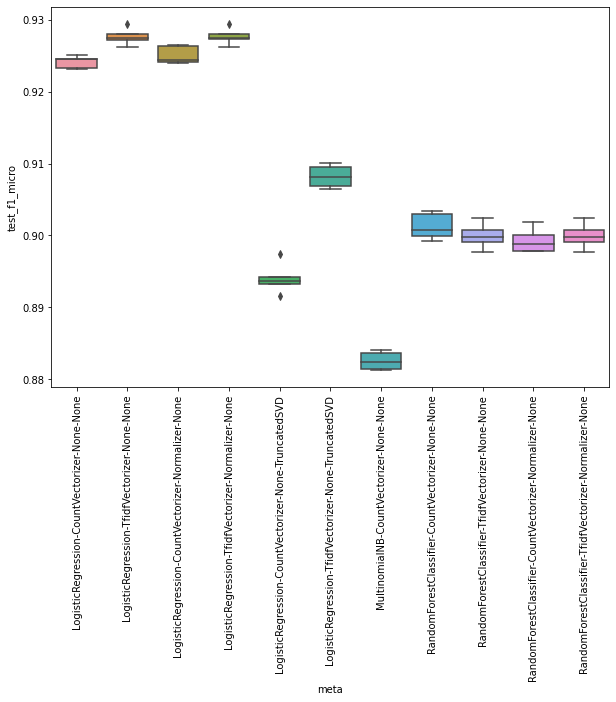

In [11]:
a4_dims = (10, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.boxplot(data=analysis_df, x="meta", y="test_f1_micro")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)

In [14]:
analysis_df.to_csv("sklearn_performance.csv", index=False)